In [1]:
import numpy as np
from numpy import squeeze, ceil, real
from scipy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path


# from skimage.util import random_noise
import os
from scipy.stats import norm


from make_otf2 import make_otf, make_pupil
from simulate_moon import simulate_moon
from make_long_otf2 import make_long_otf
from detector_blur import detector_blur
from simulate_coronagraph import *

from make_short_otf import *

# paths TODO: make OS agnostic
source_file_path = Path(os.getcwd()) / "source_files"
figures_path = Path(os.getcwd()) / "figures" / "star_sim"

## Flag for generating plots
gen_plots = False

In [2]:
def plot_OTF(OTF, name):

    if gen_plots:
        # Plot Tele OTF
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

        # Make data.
        fmax = (D - obs) / (2 * lamb * f)
        fs = fmax * 2
        df = fs / si
        X = np.arange(-fmax, fmax, df) / 1e3
        Y = X
        X, Y = np.meshgrid(X, Y)

        # Plot the surface.
        ax.set_xlabel("x Spatial Frequency (kilocycles/m)")
        ax.set_ylabel("y Spatial Frequency (kilocycles/m)")
        ax.set_zlabel("Magnitude")
        surf = ax.plot_surface(X, Y, abs(fftshift(OTF)), cmap=cm.winter)
        plt.title(name + " OTF")

        fig_name = name + "_OTF"
        plt.savefig(figures_path / fig_name)
        plt.close()
    else:
        pass


def plot_img(img, name):
    if gen_plots:
        plt.imshow(img)
        # plt.xlabel('Meters')
        # plt.ylabel('Meters')
        plt.title(name + " Image")
        plt.tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )

        fig_name = name + "_img"
        plt.savefig(figures_path / fig_name)
        plt.close()
    else:
        pass


class my_model:

    def gen_tele_OTF(self):
        tele_pupil = make_pupil(self.r1, self.r2, self.si)
        [tele_OTF, tele_psf] = make_otf(self.scale, tele_pupil)

        plot_OTF(tele_OTF, "Telescope")

        return tele_OTF

    def gen_detector_OTF(self):
        detector_OTF = detector_blur(2, 2, self.si)
        plot_OTF(detector_OTF, "Detector")
        return detector_OTF

    def gen_short_OTF(self):
        short_OTF = np.zeros((len(self.ro), self.si, self.si))
        for i in range(len(self.ro)):
            short_OTF[i] = make_short_otf2(self.r1a, self.dx, self.si, self.ro[i])
        plot_OTF(short_OTF[0], "Short")
        return short_OTF

    def gen_sys_OTF(self):
        sys_OTF = self.detector_OTF * self.tele_OTF
        plot_OTF(sys_OTF, "System")
        return sys_OTF

    def gen_turb_OTF(self):
        turb_otf = self.short_OTF * self.tele_OTF
        plot_OTF(turb_otf[0], "Turbulent")
        return turb_otf

    def gen_total_short_OTF(self):
        tot_OTF = self.turb_OTF * self.detector_OTF
        plot_OTF(tot_OTF[0], "Total")
        return tot_OTF

    ### Star Sim
    def gen_star_out_img(self, readout_std):
        num_ro = len(self.ro)
        star = np.ones([num_ro, self.si, self.si])
        star[:, int(si / 2), int(si / 2)] = 10e3

        star = real(ifft2(np.multiply(self.total_short_OTF[:], fft2(star[:]))))

        noisy_star = np.random.normal(
            np.random.poisson(
                star[:, :: self.down_sample_factor, :: self.down_sample_factor]
            ),
            readout_std,
        )
        plot_img(noisy_star[0, 740:760, 740:760], "Noisy Star")
        return noisy_star

    def __init__(
        self,
        Diameter,
        Obscuration,
        lamb,
        focal_length,
        si,
        Phase,
        dt,
        scale,
        z,
        ro,
        r1a,
    ):
        self.D = Diameter
        self.obs = Obscuration
        self.lamb = lamb
        self.f = focal_length
        self.si = si
        self.phase = Phase
        self.dt = dt
        self.scale = scale
        self.pixel_per_meter = self.si / (2 * self.D)  # array is 5x5 meter
        self.dm = 1 / self.pixel_per_meter  # distance between pixels in meters
        self.r1 = (D / 2) * self.pixel_per_meter  # radius of telescope in pixels
        self.r2 = (obs / 2) * self.pixel_per_meter  # radius of obscuration in pixels

        # Atmosphere params
        self.z = z  # Karman Line
        self.ro = ro  # seeing parameter
        self.r1a = r1a  # radius in m for turbulence calcs
        self.dx = 4 * self.r1a / self.si  # x steps for turbulence calculations

        ## image params
        self.down_sample_factor = 2
        self.std_readOut = 4

        self.tele_OTF = self.gen_tele_OTF()
        self.detector_OTF = self.gen_detector_OTF()
        self.sys_OTF = self.gen_sys_OTF()

        self.short_OTF = self.gen_short_OTF()
        self.turb_OTF = self.gen_turb_OTF()

        self.total_short_OTF = self.gen_total_short_OTF()

        self.star_sim = self.gen_star_out_img(self.std_readOut)
        # self.tele_OTF = self.gen_tele_otf()


In [3]:
# Telescope Parameters
D = 0.07  # diameter of telescope in meters
obs = 0  # obscuration diameter
lamb = 610 * 10 ** (-9)  # wavelength of length in meters
f = 0.4  # focal length in meters
si = 3000  # ccd pixel dimensions
scale = 1  # value at dc
phase = np.zeros([si, si])  # zero for non-abberated system
dt = 100.0e-3  # CCD integration time

# Atmosphere Parameters
z = 100 * 10**3  # Karman line ~ 100km
ro = np.linspace(0.001, 0.02, 20)  # seeing parameter
r1a = D / 2  # radius used for turbulence calculations

model = my_model(D, obs, lamb, f, si, phase, dt, scale, z, ro, r1a)

In [242]:
interval = 10
middle = int(si/4)
left,right = [middle-int(interval/2), middle+int(interval/2)]

sys_otf = model.sys_OTF
downscale_factor = model.down_sample_factor
ro_est = np.zeros(len(ro))
for i in range(len(ro)):
    patch = model.star_sim[i, left:right, left:right]
    twod_imp = (patch - np.mean(patch)) / np.std(patch)
    
    corr_vals = np.zeros(num_ro)
    for j in range(len(ro)):
        ##Estimate PSF
        total_otf_temp = model.total_short_OTF[j]
        total_psf_temp = fftshift(ifft2(total_otf_temp))
        samp_psf = total_psf_temp[::downscale_factor, ::downscale_factor]
        samp_patch = samp_psf[left:right, left:right]
        imp_est = (samp_patch - np.mean(samp_patch)) / np.std(samp_patch)
        corr_vals[j] = np.mean(np.multiply(twod_imp, imp_est.real))

    ro_est[i] = np.argmax(corr_vals) / 1e3 + 0.001



print(ro_est)

[0.001 0.02  0.02  0.001 0.009 0.006 0.002 0.01  0.011 0.011 0.011 0.013
 0.013 0.015 0.015 0.016 0.016 0.017 0.019 0.02 ]


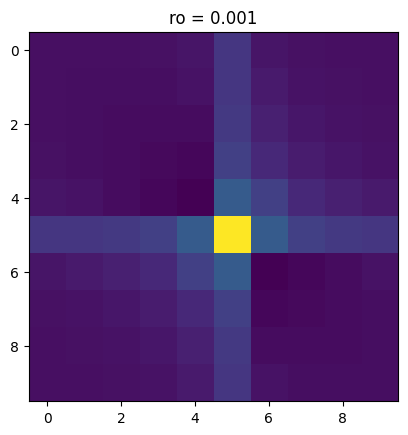

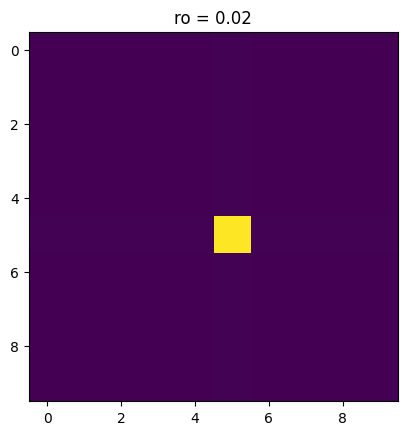

In [247]:
## plot total_short_PSFs
plt.imshow(fftshift(ifft2(model.total_short_OTF[1, left:right, left:right])).real)
plt.title('ro = 0.001')
plt.show()

plt.imshow(fftshift(ifft2(model.total_short_OTF[19, left:right, left:right])).real)
plt.title('ro = 0.02')
plt.show()

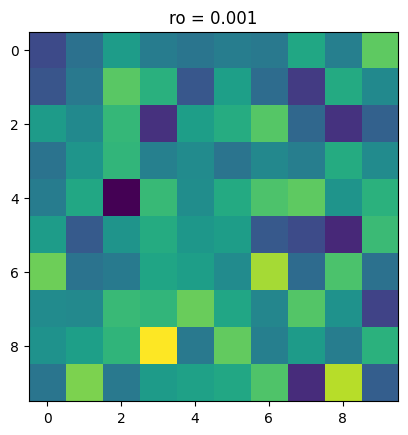

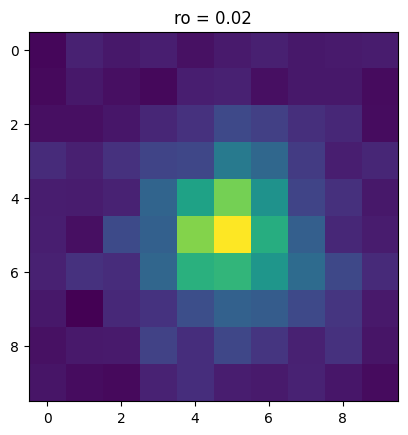

In [248]:
total_psf = fftshift(ifft2(model.star_sim))
down_psf = total_psf_temp[::downscale_factor, ::downscale_factor]

## plot star sims
plt.imshow(model.star_sim[0, left:right, left:right])
plt.title('ro = 0.001')
plt.show()

plt.imshow(model.star_sim[19, left:right, left:right])
plt.title('ro = 0.02')
plt.show()

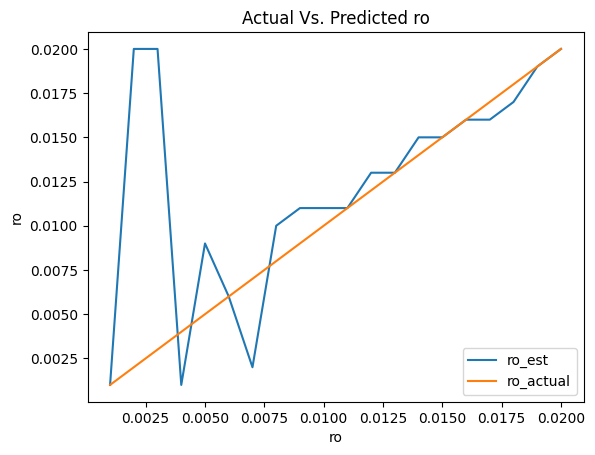

In [249]:
plt.plot(ro,ro_est, label='ro_est')
plt.plot(ro,ro, label='ro_actual')
plt.legend()
plt.xlabel('ro')
plt.ylabel('ro')
plt.title('Actual Vs. Predicted ro')
plt.show()

In [200]:
gen_plots = True
plot_OTF(model.short_OTF[19], 'short_otf_ro_02')

In [206]:
np.amax(model.star_sim[0])
np.amin(model.star_sim[0])

np.float64(-23.269218095825355)

In [207]:
np.amax(model.star_sim[19])
np.amin(model.star_sim[19])

np.float64(-18.039367060961577)